In [2]:
library(ggplot2)
library(dplyr)
library(tidyverse)
library(SPRING)
library(phyloseq)
library(NetCoMi)

In [3]:
# ggplot theme #
my_theme0 <- theme(panel.background = element_rect(fill = "transparent", 
                                                colour = NA), plot.background = element_rect(colour = 'NA', 
                                                                                             fill = 'transparent'),panel.grid.major=element_line(color=NA),
                axis.line=element_line(size=1.2,color="black"),
                axis.ticks=element_line(color="black"),
                axis.text=element_text(color="black",size=26),
                axis.title=element_text(color="black",size=30),
                panel.grid.minor = element_line(colour = NA),
                legend.text=element_text(size=17),legend.key=element_rect(fill="white"),
                legend.title=element_text(size=18,face="bold"),
                axis.text.x=element_text(angle=60,size=26,vjust=0.5),
                panel.border = element_rect(colour = "black", fill=NA, size=1),
                legend.position = "none")

my_theme1 <- theme_bw() + 
  theme(panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        text = element_text(size = 16),
        axis.title.x = element_text(size=18, color="black"), 
        axis.title.y = element_text(size=18, color="black"), 
        axis.text.x = element_text(angle = 0, hjust = 1, color="black"), 
        panel.grid.minor.x = element_line(colour = "grey", size=0.2, linetype = 'dashed'), 
        panel.grid.major.x = element_line(colour = "grey", size=0.2),
        panel.grid.minor.y = element_line(colour = "grey", size = 0.2, linetype = 'dashed'),
        panel.grid.major.y = element_line(colour = "grey", size=0.2),
        legend.position = "bottom", 
        legend.text=element_text(size=10), 
        legend.key.size = unit(1,"line"), 
        plot.margin=unit(c(1,1,1,1),"cm")
       ) 

In [39]:
# modified from https://www.biostars.org/p/455240/
phyloflashToPhyloseq <- function(
    tax,
    metadat=NULL,
    split=";"){
    ## tax is a matrix or data.frame with the table of taxonomic abundances, rows are taxa, columns are samples
    ## metadat is an optional data.frame of specimen metadata, rows are samples, columns are variables
    ## if simplenames=TRUE, use only the most detailed level of taxa names in the final object
    ## if roundtointeger=TRUE, values will be rounded to the nearest integer
    xnames = rownames(tax)
    x2 = strsplit(xnames, split=split, fixed=TRUE)
    taxmat = matrix(NA, ncol=max(sapply(x2, length)), nrow=length(x2))
    colnames(taxmat) = c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")[1:ncol(taxmat)]
    rownames(taxmat) = xnames
    for (i in 1:nrow(taxmat)){
        taxmat[i, 1:length(x2[[i]])] <- x2[[i]]
    }
    taxmat = gsub("[()]", "", taxmat)
    taxmat = phyloseq::tax_table(taxmat)
    otutab = phyloseq::otu_table(tax, taxa_are_rows=TRUE)
    if(is.null(metadat)){
        res = phyloseq::phyloseq(taxmat, otutab)
    }else{
        res = phyloseq::phyloseq(taxmat, otutab, phyloseq::sample_data(metadat))
    }
    return(res)
}

In [63]:
metadata_file <- "/home/shengwei/VirEncAct/@@DEF_Visualization/plot_bioGEOTRACES/biogeotraces_metadata_v2.tsv"
metadata_df <- read.table(metadata_file, header = T, sep = "\t", as.is = T, stringsAsFactors = F)
GA02_meta_df <- metadata_df %>%
  filter(GEOTRACES_Section == "GA02") %>% 
  select(NCBI_SRA_Acc, Collection_Year, Collection_Month, Collection_Date, Cruise_Station, Latitude, Longitude, Depth)
head(GA02_meta_df, 2)

,NCBI_SRA_Acc,Collection_Year,Collection_Month,Collection_Date,Cruise_Station,Latitude,Longitude,Depth
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,SRR5788236,2010,5,5/10/2010,10,49.7225,-42.4467,10
2,SRR5788235,2010,5,5/10/2010,10,49.7225,-42.4467,50


In [66]:
LatitudeRange_order <- rev(c("S50-S45", "S45-S40", "S40-S35", "S35-S30", "S30-S25", "S25-S20", "S20-S10", "S10-S0", 
                         "N0-N10", "N10-N20", "N20-N25", "N25-N30", "N30-N35", "N35-N40", "N45-N50"))
DepthRange_order <- c("D8-D12", "D49-D52", "D61-D80", "D87-D103", "D119-D153", "D198-D202")

GA02_meta_df2 <- GA02_meta_df %>% 
  mutate(LatitudeRange = case_when(Latitude>-50 & Latitude<= -45 ~ "S50-S45",
                                   Latitude>-45 & Latitude<= -40 ~ "S45-S40",
                                   Latitude>-40 & Latitude<= -35 ~ "S40-S35",
                                   Latitude>-35 & Latitude<= -30 ~ "S35-S30",
                                   Latitude>-30 & Latitude<= -25 ~ "S30-S25",
                                   Latitude>-25 & Latitude<= -20 ~ "S25-S20",
                                   Latitude>-20 & Latitude<= -10 ~ "S20-S10",
                                   Latitude>-10 & Latitude<= 0 ~ "S10-S0",
                                   Latitude>0 & Latitude<= 10 ~ "N0-N10",
                                   Latitude>10 & Latitude<= 20 ~ "N10-N20",
                                   Latitude>20 & Latitude<= 25 ~ "N20-N25",
                                   Latitude>25 & Latitude<= 30 ~ "N25-N30",
                                   Latitude>30 & Latitude<= 35 ~ "N30-N35",
                                   Latitude>35 & Latitude<= 40 ~ "N35-N40",
                                   Latitude>45 & Latitude<= 50 ~ "N45-N50")) %>%
  mutate(LatitudeRange = factor(LatitudeRange, levels = LatitudeRange_order)) %>%
  mutate(DepthRange = case_when(Depth>=8 & Depth<= 12 ~ "D8-D12",
                                Depth>=49 & Depth<= 52 ~ "D49-D52",
                                Depth>=61 & Depth<= 80 ~ "D61-D80",
                                Depth>=87 & Depth<= 103 ~ "D87-D103",
                                Depth>=119 & Depth<= 153 ~ "D119-D153",
                                Depth>=198 & Depth<= 202 ~ "D198-D202")) %>%
  mutate(DepthRange = factor(DepthRange, levels = DepthRange_order))
rownames(GA02_meta_df2) <- GA02_meta_df2$NCBI_SRA_Acc
head(GA02_meta_df2, 2)

,NCBI_SRA_Acc,Collection_Year,Collection_Month,Collection_Date,Cruise_Station,Latitude,Longitude,Depth,LatitudeRange,DepthRange
,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
SRR5788236,SRR5788236,2010,5,5/10/2010,10,49.7225,-42.4467,10,N45-N50,D8-D12
SRR5788235,SRR5788235,2010,5,5/10/2010,10,49.7225,-42.4467,50,N45-N50,D49-D52


In [90]:
merged_phyloflash_tbl <- "/home/shengwei/GitHub/projects/bioGEOTRACES/merged_phyloFlash_abundance.tsv"
merged_phyloflash_df <- read.table(merged_phyloflash_tbl, header = T, row.names = 1, sep = "\t", as.is = T, strip.white=T, fill=T, stringsAsFactors = F)
head(merged_phyloflash_df, 2)

,SRR5720219,SRR5720226,SRR5720228,SRR5720246,SRR5720250,SRR5720299,SRR5720308,SRR5720343,SRR5787998,SRR5788030,⋯,SRR5788463,SRR5788156,SRR5720297,SRR5788301,SRR5788125,SRR5788152,SRR5788461,SRR5788117,SRR6507277,SRR6507280
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Eukaryota;SAR;Stramenopiles;MAST-3;MAST-3E;uncultured marine eukaryote;(uncultured marine eukaryote),0,1,0,0,0,0,2,0,3,0,⋯,1,0,0,0,0,0,0,0,0,0
Bacteria;Proteobacteria;Deltaproteobacteria;NB1-j;uncultured organism;(uncultured organism);(uncultured organism),0,0,0,0,1,0,0,0,0,0,⋯,1,0,2,0,0,0,0,0,0,0


In [91]:
GA02_phyloflash_df <- merged_phyloflash_df[, rownames(GA02_meta_df2)]
ncol(GA02_phyloflash_df)

[1] 127

In [92]:
ps <- phyloflashToPhyloseq(GA02_phyloflash_df, metadat=GA02_meta_df2)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7605 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 7605 taxa by 7 taxonomic ranks ]

In [93]:
ps.prok = subset_taxa(ps, Kingdom %in% c("Bacteria", "Archaea"))
ps.prok

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6113 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 6113 taxa by 7 taxonomic ranks ]

In [94]:
ps.euk = subset_taxa(ps, Kingdom %in% c("Eukaryota"))
ps.euk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1492 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 1492 taxa by 7 taxonomic ranks ]

In [ ]:
ps.euk

In [70]:
### covert to relative abundance
ps.ra <- transform_sample_counts(ps, function(x) 100*x/sum(x))
ps.ra

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7605 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 7605 taxa by 7 taxonomic ranks ]

In [71]:
## print the available taxonomic ranks
colnames(tax_table(ps.ra))
## agglomerate at the Family taxonomic rank
(ps.ra.family <- tax_glom(ps, taxrank="Family", NArm = FALSE))
## How many taxa before/after agglomeration?
ntaxa(ps.ra); ntaxa(ps.ra.family)

[1] "Kingdom" "Phylum"  "Class"   "Order"   "Family"  "Genus"   "Species"

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2207 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 2207 taxa by 7 taxonomic ranks ]

[1] 7605

[1] 2207

In [72]:
## agglomerate at the Class taxonomic rank
(ps.ra.class <- tax_glom(ps, taxrank="Class", NArm = FALSE))
## How many taxa before/after agglomeration?
ntaxa(ps.ra); ntaxa(ps.ra.class)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 351 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 351 taxa by 7 taxonomic ranks ]

[1] 7605

[1] 351

In [96]:
## agglomerate at the Class taxonomic rank
(ps.ra.kingdom <- tax_glom(ps, taxrank="Kingdom", NArm = FALSE))
## How many taxa before/after agglomeration?
ntaxa(ps.ra); ntaxa(ps.ra.kingdom)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 3 taxa by 7 taxonomic ranks ]

[1] 7605

[1] 3

In [75]:
library("RColorBrewer")

# sort abundance table accroding to sample metadata
# the metadata has to be in data.frame, not phyloseq sample.data format
sample_metadata <- data.frame(sample_data(ps.ra.class)[, c("DepthRange", "LatitudeRange")])
sample_metadata <- with(sample_metadata, sample_metadata[order(LatitudeRange, DepthRange),])

depth_levels <- levels(sample_metadata$DepthRange)
depth_colors <- setNames(brewer.pal(length(depth_levels), "BuPu"), depth_levels)
latitude_levels <- levels(sample_metadata$LatitudeRange)
latitude_colors <- setNames(colorRampPalette(brewer.pal(11, "RdYlGn"))(length(latitude_levels)), latitude_levels)

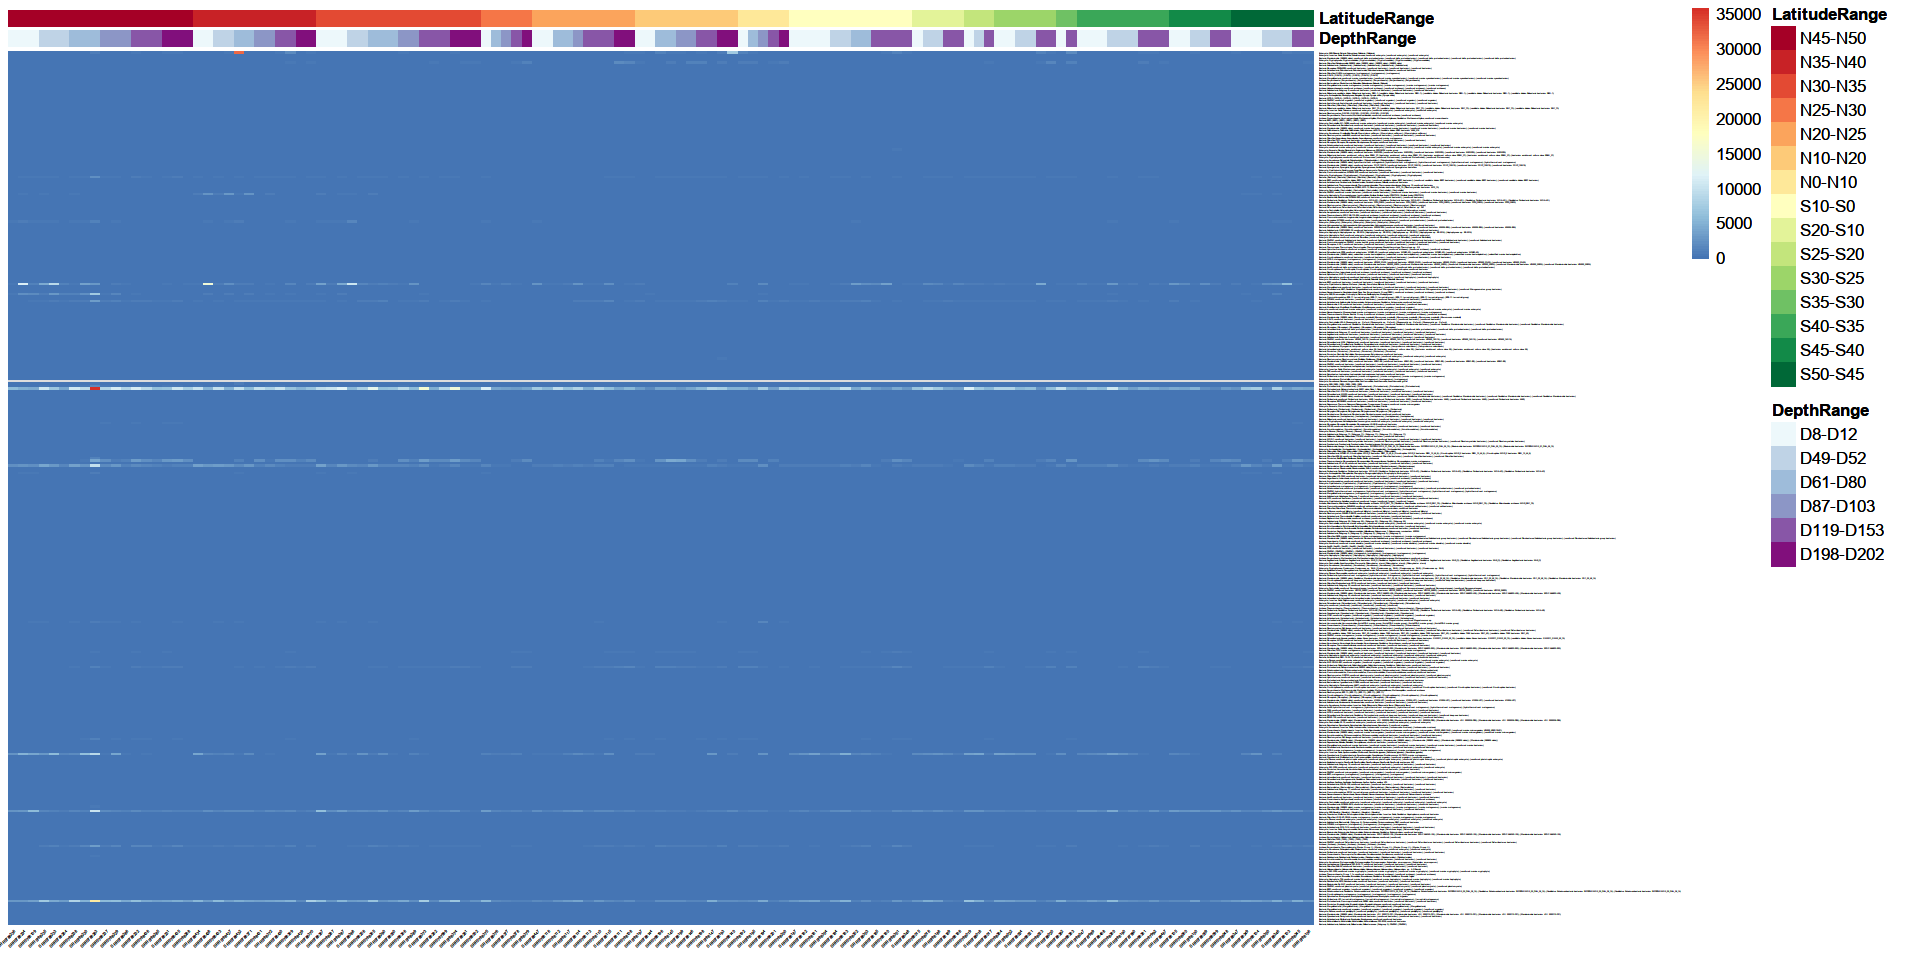

In [101]:
options(repr.plot.width=16, repr.plot.height=8)

library(pheatmap)
class_abund <- otu_table(ps.ra.class)
class_abund <- class_abund[, rownames(sample_metadata)]
pheat.class <- pheatmap(class_abund, 
         #legend_breaks = 0:3, legend_labels = paste('1e', 0:3, sep=''), 
         cluster_cols = F, 
         cluster_rows = F, 
         annotation_col = sample_metadata,     
         annotation_colors = list(
             DepthRange = depth_colors,
             LatitudeRange = latitude_colors),
         fontsize_col = 2, 
         fontsize_row = 1, 
         angle_col = 45,
         cutree_rows = 1,
         show_rownames = T)

print(pheat.class)

In [106]:
library("RColorBrewer")

# sort abundance table accroding to sample metadata
# the metadata has to be in data.frame, not phyloseq sample.data format
sample_metadata <- data.frame(sample_data(ps.ra.kingdom)[, c("DepthRange", "LatitudeRange")])
sample_metadata <- with(sample_metadata, sample_metadata[order(LatitudeRange, DepthRange),])

depth_levels <- levels(sample_metadata$DepthRange)
depth_colors <- setNames(brewer.pal(length(depth_levels), "BuPu"), depth_levels)
latitude_levels <- levels(sample_metadata$LatitudeRange)
latitude_colors <- setNames(colorRampPalette(brewer.pal(11, "RdYlGn"))(length(latitude_levels)), latitude_levels)

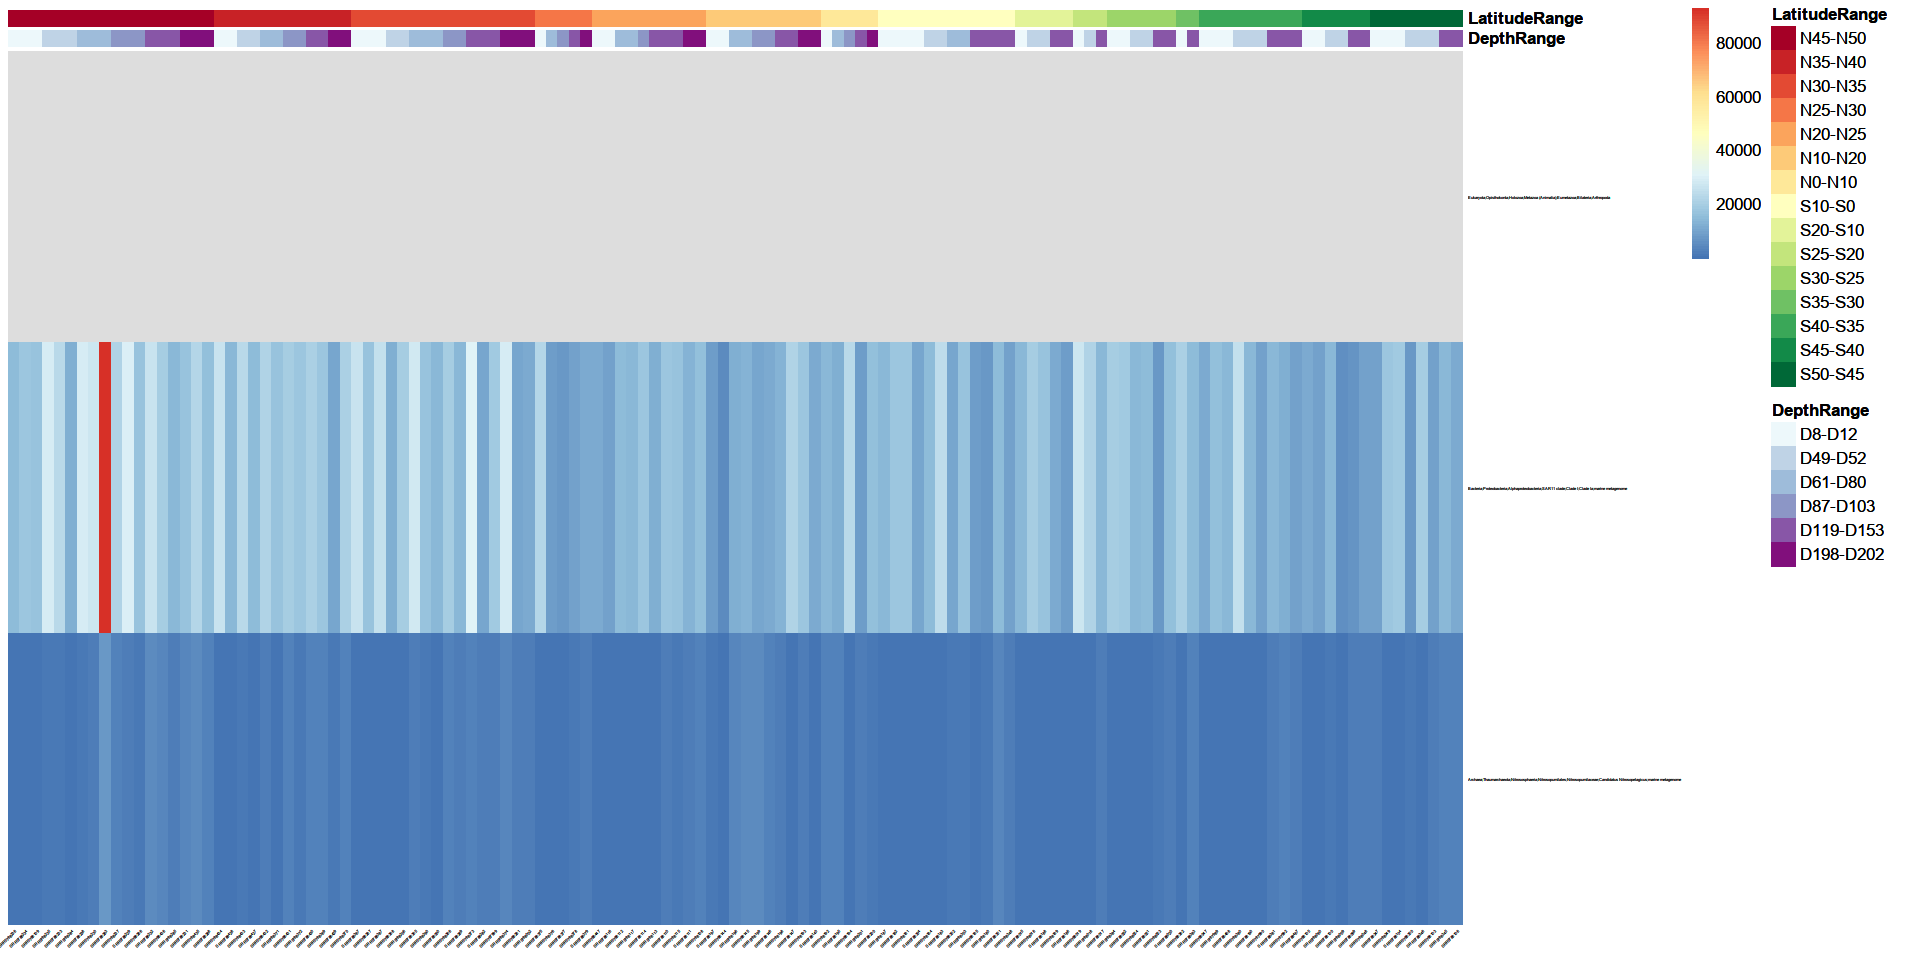

In [108]:
options(repr.plot.width=16, repr.plot.height=8)

library(pheatmap)
kingdom_abund <- otu_table(ps.ra.kingdom)
kingdom_abund <- kingdom_abund[, rownames(sample_metadata)]
pheat.kingdom <- pheatmap(kingdom_abund, 
         #legend_breaks = 0:3, legend_labels = paste('1e', 0:3, sep=''), 
         cluster_cols = F, 
         cluster_rows = F, 
         annotation_col = sample_metadata,     
         annotation_colors = list(
             DepthRange = depth_colors,
             LatitudeRange = latitude_colors),
         fontsize_col = 2, 
         fontsize_row = 2, 
         angle_col = 45,
         cutree_rows = 1,
         show_rownames = T)

print(pheat.kingdom)